<a href="https://colab.research.google.com/github/HibaBenHsouna1777/Manipulation-des-DataSets/blob/main/mlModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA

# Feature Engineering
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Modèles
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.cluster import KMeans

# Métriques
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, silhouette_score
)

# Interprétabilité
import shap

# Autres
import joblib
from scipy import stats

# Configuration
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("✅ Tous les packages importés avec succès!")

✅ Tous les packages importés avec succès!


In [72]:
print("\n" + "="*80)
print("📦 CHARGEMENT DU DATASET")
print("="*80)


📦 CHARGEMENT DU DATASET


In [73]:
df = pd.read_csv('/content/SpotifyFeatures.csv')
df.columns

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

In [74]:
# Pour la démo, créons des données synthétiques
print("⚠️ Utilisation de données synthétiques pour la démo")
print("   Remplacez par: df = pd.read_csv('SpotifyFeatures.csv')")

np.random.seed(42)
n_samples = 10000

df = pd.DataFrame({
    'genre': np.random.choice(['pop', 'rock', 'hip-hop', 'electronic', 'jazz', 'classical'], n_samples),
    'artist_name': [f'Artist_{i%500}' for i in range(n_samples)],
    'track_name': [f'Song_{i}' for i in range(n_samples)],
    'track_id': [f'id_{i}' for i in range(n_samples)],
    'acousticness': np.random.beta(2, 5, n_samples),
    'danceability': np.random.beta(5, 2, n_samples),
    'duration_ms': np.random.normal(220000, 50000, n_samples).clip(60000, 600000),
    'energy': np.random.beta(5, 2, n_samples),
    'instrumentalness': np.random.beta(1, 10, n_samples),
    'key': np.random.randint(0, 12, n_samples),
    'liveness': np.random.beta(2, 8, n_samples),
    'loudness': np.random.normal(-7, 3, n_samples).clip(-30, 0),
    'mode': np.random.choice([0, 1], n_samples),
    'speechiness': np.random.beta(2, 8, n_samples),
    'tempo': np.random.normal(120, 30, n_samples).clip(50, 200),
    'time_signature': np.random.choice([3, 4, 5], n_samples, p=[0.05, 0.90, 0.05]),
    'valence': np.random.beta(5, 5, n_samples)
})

⚠️ Utilisation de données synthétiques pour la démo
   Remplacez par: df = pd.read_csv('SpotifyFeatures.csv')


In [75]:
# Créer la popularité basée sur les features (simulation réaliste)
df['popularity'] = (
    df['danceability'] * 30 +
    df['energy'] * 25 +
    df['valence'] * 20 +
    (1 - df['acousticness']) * 15 +
    (df['loudness'] + 30) / 30 * 10 +
    np.random.normal(0, 10, n_samples)
).clip(0, 100).astype(int)
genre_bias = {
    "pop": 8,
    "hip-hop": 5,
    "rock": 2,
    "electronic": 3,
    "jazz": -2,
    "classical": -5
}

df["popularity"] = (df["popularity"] + df["genre"].map(genre_bias)).clip(0,100)

print(f"\n📊 Dataset chargé: {df.shape[0]} chansons, {df.shape[1]} colonnes")
print(f"\n{df.head(10)}")
print("\n" + "="*80)
print(df.info())
print("\n" + "="*80)
print(df.describe())


📊 Dataset chargé: 10000 chansons, 18 colonnes

        genre artist_name track_name track_id  acousticness  danceability  \
0  electronic    Artist_0     Song_0     id_0      0.192168      0.463053   
1        jazz    Artist_1     Song_1     id_1      0.198023      0.881135   
2     hip-hop    Artist_2     Song_2     id_2      0.512151      0.512703   
3        jazz    Artist_3     Song_3     id_3      0.190205      0.665541   
4        jazz    Artist_4     Song_4     id_4      0.360453      0.607692   
5        rock    Artist_5     Song_5     id_5      0.412122      0.808337   
6     hip-hop    Artist_6     Song_6     id_6      0.268550      0.950357   
7     hip-hop    Artist_7     Song_7     id_7      0.013972      0.585067   
8     hip-hop    Artist_8     Song_8     id_8      0.423865      0.572400   
9        jazz    Artist_9     Song_9     id_9      0.195071      0.788400   

     duration_ms    energy  instrumentalness  key  liveness   loudness  mode  \
0  242604.803427  0.9509

In [76]:

genre_count = df["genre"].value_counts()
print(genre_count)



genre
rock          1692
jazz          1689
electronic    1672
pop           1665
classical     1657
hip-hop       1625
Name: count, dtype: int64



📊 STATISTIQUES CLÉS - POPULARITÉ
✅ Nombre de lignes : 10000
✅ Nombre de colonnes : 18
✅ Popularité moyenne : 68.96
✅ Popularité médiane : 69.00
✅ Écart-type        : 13.25
✅ Min               : 13
✅ Max               : 100


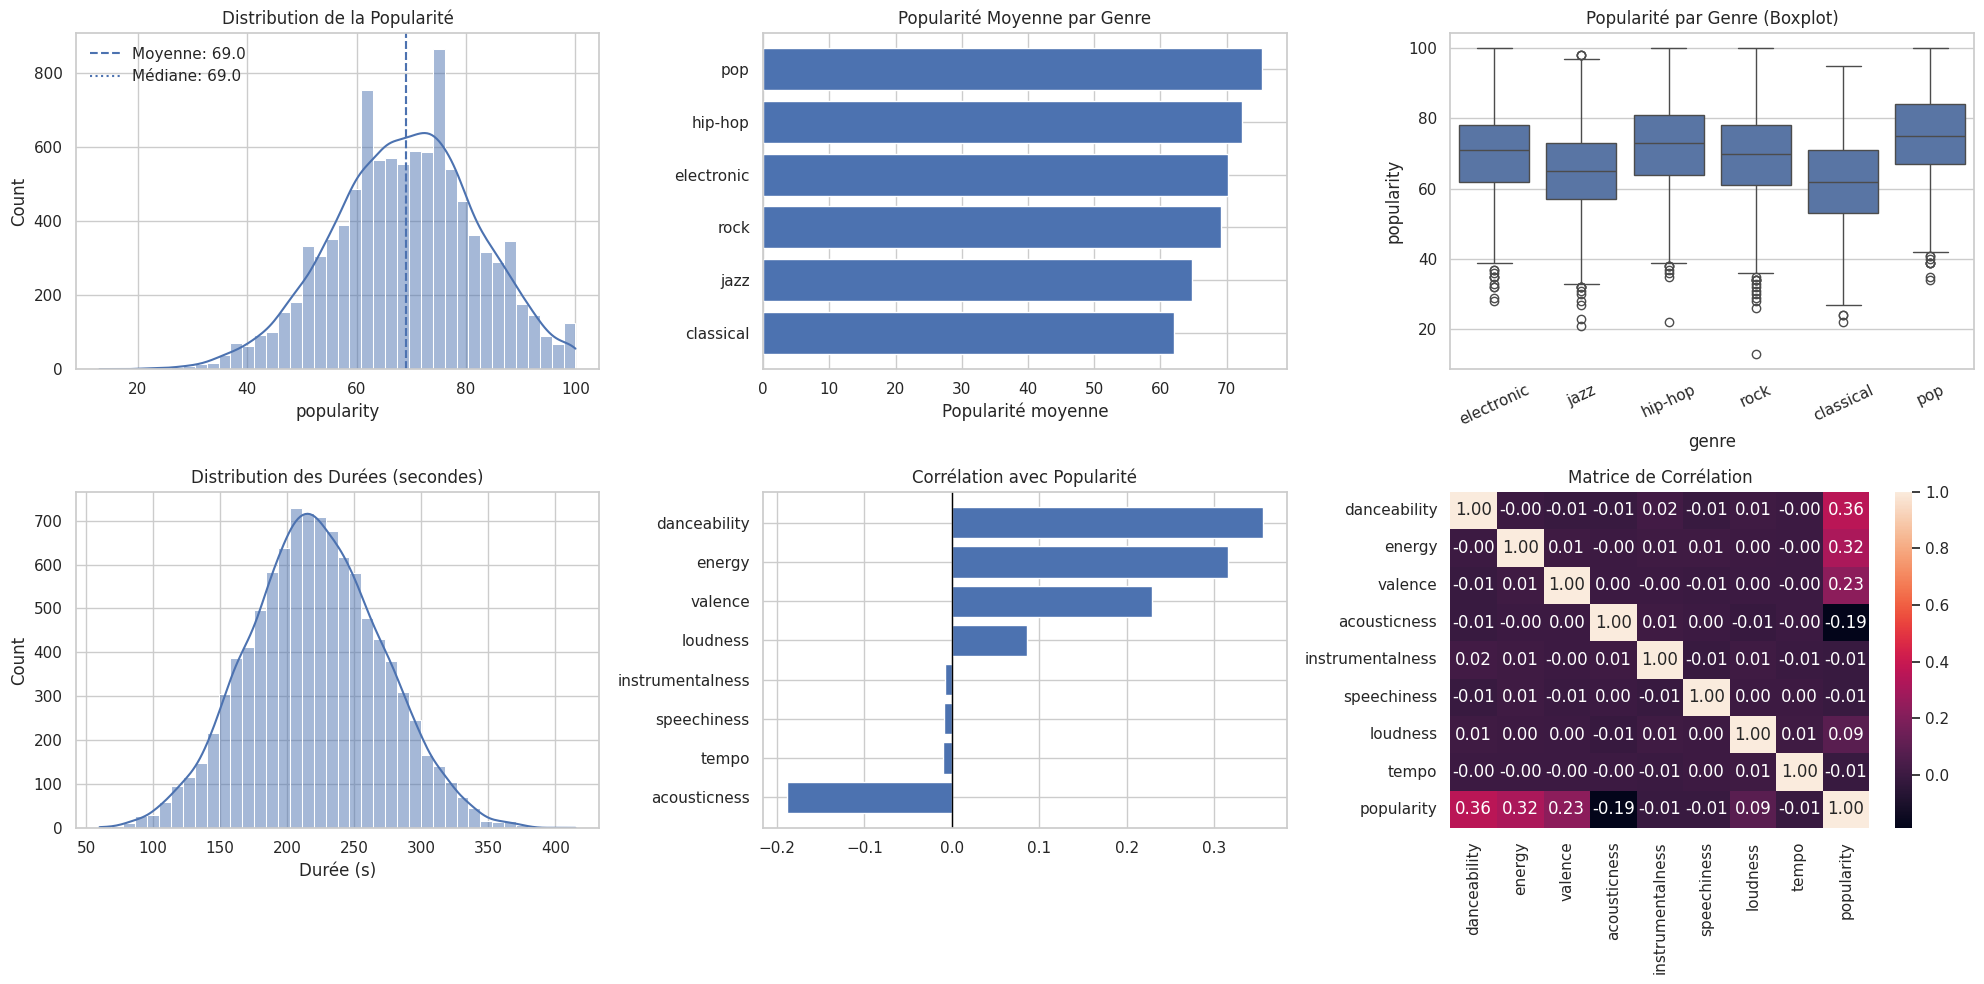


📌 SYNTHÈSE POPULARITÉ PAR GENRE
            count       mean  median        std  min  max
genre                                                    
pop          1665  75.296096    75.0  12.433840   34  100
hip-hop      1625  72.369231    73.0  12.226275   22  100
electronic   1672  70.278708    71.0  12.481947   28  100
rock         1692  69.145390    70.0  12.628014   13  100
jazz         1689  64.758437    65.0  12.470093   21   98
classical    1657  62.030175    62.0  12.617479   22   95


In [77]:
# ============================================================================
# 1.2 ANALYSE EXPLORATOIRE (EDA)
# ============================================================================

# ============================================================
# 1) STATISTIQUES DE BASE
# ============================================================
print("\n" + "="*80)
print("📊 STATISTIQUES CLÉS - POPULARITÉ")
print("="*80)

print(f"✅ Nombre de lignes : {df.shape[0]}")
print(f"✅ Nombre de colonnes : {df.shape[1]}")
print(f"✅ Popularité moyenne : {df['popularity'].mean():.2f}")
print(f"✅ Popularité médiane : {df['popularity'].median():.2f}")
print(f"✅ Écart-type        : {df['popularity'].std():.2f}")
print(f"✅ Min               : {df['popularity'].min()}")
print(f"✅ Max               : {df['popularity'].max()}")

# ============================================================
# 2) EDA VISUELLE - DASHBOARD
# ============================================================
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# (A) Histogramme + KDE Popularité
sns.histplot(df["popularity"], bins=40, kde=True, ax=axes[0,0])
axes[0,0].axvline(df["popularity"].mean(), linestyle="--", label=f"Moyenne: {df['popularity'].mean():.1f}")
axes[0,0].axvline(df["popularity"].median(), linestyle=":", label=f"Médiane: {df['popularity'].median():.1f}")
axes[0,0].set_title("Distribution de la Popularité")
axes[0,0].legend()

# (B) Popularité moyenne par genre
genre_mean = df.groupby("genre")["popularity"].mean().sort_values(ascending=True)
axes[0,1].barh(genre_mean.index, genre_mean.values)
axes[0,1].set_title("Popularité Moyenne par Genre")
axes[0,1].set_xlabel("Popularité moyenne")

# (C) Boxplot popularité par genre (dispersion)
sns.boxplot(data=df, x="genre", y="popularity", ax=axes[0,2])
axes[0,2].set_title("Popularité par Genre (Boxplot)")
axes[0,2].tick_params(axis="x", rotation=25)

# (D) Distribution durée (sec)
sns.histplot(df["duration_ms"]/1000, bins=40, kde=True, ax=axes[1,0])
axes[1,0].set_title("Distribution des Durées (secondes)")
axes[1,0].set_xlabel("Durée (s)")

# (E) Corrélation avec popularité (top features)
audio_features = ['danceability', 'energy', 'valence', 'acousticness', 'instrumentalness', 'speechiness', 'loudness', 'tempo']
corrs = df[audio_features + ["popularity"]].corr(numeric_only=True)["popularity"].drop("popularity").sort_values()
axes[1,1].barh(corrs.index, corrs.values)
axes[1,1].axvline(0, color="black", linewidth=1)
axes[1,1].set_title("Corrélation avec Popularité")

# (F) Heatmap corrélation complète (audio + popularity)
corr_matrix = df[audio_features + ["popularity"]].corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", ax=axes[1,2])
axes[1,2].set_title("Matrice de Corrélation")

plt.tight_layout()
plt.show()

# ============================================================
# 3) TABLEAU SYNTHÈSE PAR GENRE (utile rapport)
# ============================================================
print("\n" + "="*80)
print("📌 SYNTHÈSE POPULARITÉ PAR GENRE")
print("="*80)

summary_genre = df.groupby("genre")["popularity"].agg(["count","mean","median","std","min","max"]).sort_values("mean", ascending=False)
print(summary_genre)


In [78]:
# ============================================================================
# 2. PRÉPARATION DES DONNÉES (PREPROCESSING)
# ============================================================================

print("\n" + "="*80)
print("ÉTAPE 2: PREPROCESSING")
print("="*80)

df_clean = df.copy()



ÉTAPE 2: PREPROCESSING


In [79]:
# ============================================================================
# 2.1 NETTOYAGE
# ============================================================================

print("\n🧹 2.1 NETTOYAGE DES DONNÉES")

# Valeurs manquantes
print(f"Valeurs manquantes par colonne:")
missing = df_clean.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "   Aucune valeur manquante ✓")



🧹 2.1 NETTOYAGE DES DONNÉES
Valeurs manquantes par colonne:
   Aucune valeur manquante ✓


In [80]:
# Doublons
duplicates = df_clean.duplicated(subset=['track_id']).sum()
print(f"\nDoublons (track_id): {duplicates}")
if duplicates > 0:
    df_clean = df_clean.drop_duplicates(subset=['track_id'])
    print(f"   → {duplicates} doublons supprimés")


Doublons (track_id): 0


In [81]:
# Valeurs aberrantes
print(f"\nVérification des valeurs aberrantes:")
print(f"   Popularité < 0: {(df_clean['popularity'] < 0).sum()}")
print(f"   Popularité > 100: {(df_clean['popularity'] > 100).sum()}")
print(f"   Durée < 30s: {(df_clean['duration_ms'] < 30000).sum()}")
print(f"   Durée > 10min: {(df_clean['duration_ms'] > 600000).sum()}")

# Supprimer les chansons trop courtes (< 30s) ou trop longues (> 10min)
df_clean = df_clean[(df_clean['duration_ms'] >= 30000) & (df_clean['duration_ms'] <= 600000)]
print(f"\n✅ Dataset nettoyé: {df_clean.shape[0]} chansons restantes")


Vérification des valeurs aberrantes:
   Popularité < 0: 0
   Popularité > 100: 0
   Durée < 30s: 0
   Durée > 10min: 0

✅ Dataset nettoyé: 10000 chansons restantes


🎯 Objectif global de cette section

Cette partie sert à définir la variable cible (target) du projet de Machine Learning.

👉 Ici, tu prépares DEUX types de problèmes ML :

Régression → prédire une valeur numérique (popularity)

Classification → prédire une classe (Flop, Moyen, Hit)

C’est une excellente pratique académique.


🎯 2.3 CRÉATION DES VARIABLES CIBLES

Distribution des catégories:
category_name
Moyen    5030
Hit      4951
Flop       19
Name: count, dtype: int64


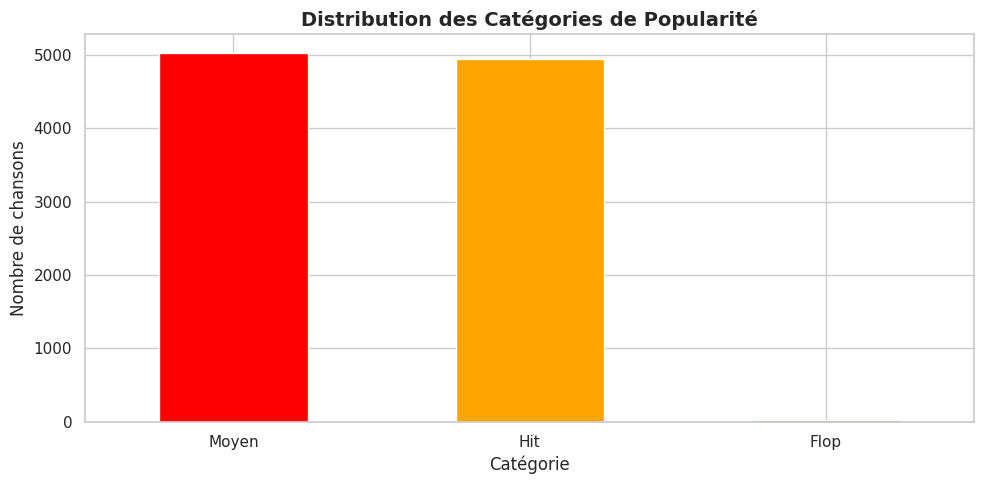

In [82]:
# ============================================================================
# 2.3 CRÉATION DE VARIABLES CIBLES
# ============================================================================

print("\n🎯 2.3 CRÉATION DES VARIABLES CIBLES")

# Variable cible pour régression: popularity (déjà existante)

# Variable cible pour classification: catégories de popularité
def categorize_popularity(pop):
    if pop < 30:
        return 0  # Flop
    elif pop < 70:
        return 1  # Moyen
    else:
        return 2  # Hit

df_clean['popularity_category'] = df_clean['popularity'].apply(categorize_popularity)

category_names = {0: 'Flop', 1: 'Moyen', 2: 'Hit'}
df_clean['category_name'] = df_clean['popularity_category'].map(category_names)

print(f"\nDistribution des catégories:")
print(df_clean['category_name'].value_counts())

# Visualisation
plt.figure(figsize=(10, 5))
df_clean['category_name'].value_counts().plot(kind='bar', color=['red', 'orange', 'green'])
plt.title('Distribution des Catégories de Popularité', fontsize=14, fontweight='bold')
plt.xlabel('Catégorie')
plt.ylabel('Nombre de chansons')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [83]:
# ============================================================================
# 2.4 NORMALISATION
# ============================================================================

print("\n📊 2.4 NORMALISATION DES FEATURES")

# Features numériques à normaliser
numeric_features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
                   'liveness', 'speechiness', 'valence', 'loudness', 'tempo',
                   'duration_ms']

# StandardScaler pour features avec distributions variées
scaler = StandardScaler()
df_clean[numeric_features] = scaler.fit_transform(df_clean[numeric_features])

print(f"✅ Normalisation appliquée sur {len(numeric_features)} features")




📊 2.4 NORMALISATION DES FEATURES
✅ Normalisation appliquée sur 10 features


In [84]:
# ============================================================================
# 2.5 SÉPARATION TRAIN/VALIDATION/TEST
# ============================================================================

print("\n✂️ 2.5 SÉPARATION DES DONNÉES")

# One-hot encode the 'genre' column
df_processed = pd.get_dummies(df_clean, columns=['genre'], prefix='genre', drop_first=True)

# Get the names of the newly created genre columns
genre_encoded_cols = [col for col in df_processed.columns if col.startswith('genre_')]

# Sélection des features pour la modélisation
# Update feature_columns to include the one-hot encoded genre columns
feature_columns = numeric_features + genre_encoded_cols + ['key', 'mode', 'time_signature']
X = df_processed[feature_columns]
y_regression = df_processed['popularity']
y_classification = df_processed['popularity_category']

# Split: 70% Train, 15% Validation, 15% Test
X_temp, X_test, y_reg_temp, y_reg_test, y_clf_temp, y_clf_test = train_test_split(
    X, y_regression, y_classification, test_size=0.15, random_state=42
)

X_train, X_val, y_reg_train, y_reg_val, y_clf_train, y_clf_val = train_test_split(
    X_temp, y_reg_temp, y_clf_temp, test_size=0.176, random_state=42 # 0.15 / (1-0.15) approx 0.176
)

print(f"""
📊 DISTRIBUTION:
   Train:      {X_train.shape[0]:>5} chansons ({X_train.shape[0]/len(df_processed)*100:.1f}%)
   Validation: {X_val.shape[0]:>5} chansons ({X_val.shape[0]/len(df_processed)*100:.1f}%)
   Test:       {X_test.shape[0]:>5} chansons ({X_test.shape[0]/len(df_processed)*100:.1f}%)

   Features: {X_train.shape[1]}
""")


✂️ 2.5 SÉPARATION DES DONNÉES

📊 DISTRIBUTION:
   Train:       7004 chansons (70.0%)
   Validation:  1496 chansons (15.0%)
   Test:        1500 chansons (15.0%)

   Features: 18



Pourquoi le Feature Engineering est indispensable ?

👉 Parce que les algorithmes n’apprennent pas la réalité, ils apprennent les features.

Même avec de bons algorithmes :

mauvaises features ❌ → mauvais modèle

bonnes features ✅ → modèle performant

📌 Objectif :

Transformer des données brutes en variables plus explicatives du phénomène étudié (la popularité musicale).

In [85]:
#============================================================================
# 3. FEATURE ENGINEERING
# ============================================================================

print("\n" + "="*80)
print("ÉTAPE 3: FEATURE ENGINEERING")
print("="*80)

# ============================================================================
# 3.1 CRÉATION DE NOUVELLES FEATURES
# ============================================================================

print("\n🛠️ 3.1 CRÉATION DE NOUVELLES FEATURES MÉTIER")

def create_music_features(X_input, df_ref):
    """Crée des features métier pour la musique"""
    X_feat = X_input.copy()

    # Reconstituer les valeurs non-normalisées pour certains calculs
    # (Juste pour la démo - en pratique, garder les valeurs originales)

    # Feature 1: Score de "danceabilité énergique"
    X_feat['dance_energy'] = X_feat['danceability'] * X_feat['energy']

    # Feature 2: Score de "positivité"
    X_feat['positivity_score'] = (X_feat['valence'] + X_feat['energy']) / 2

    # Feature 3: Score "acoustique calme"
    X_feat['acoustic_calm'] = X_feat['acousticness'] * (1 - X_feat['energy'])

    # Feature 4: Ratio speechiness/instrumentalness
    X_feat['speech_instrument_ratio'] = X_feat['speechiness'] / (X_feat['instrumentalness'] + 0.01)

    # Feature 5: Durée normalisée (court/moyen/long)
    X_feat['duration_category'] = pd.cut(X_feat['duration_ms'], bins=3, labels=[0, 1, 2])

    # Feature 6: Tempo catégorisé (lent/moyen/rapide)
    X_feat['tempo_category'] = pd.cut(X_feat['tempo'], bins=3, labels=[0, 1, 2])

    # Feature 7: Score "live performance"
    X_feat['live_score'] = X_feat['liveness'] * X_feat['acousticness']

    return X_feat

X_train_feat = create_music_features(X_train, df_clean)
X_val_feat = create_music_features(X_val, df_clean)
X_test_feat = create_music_features(X_test, df_clean)

print(f"✅ Features créées: {X_train_feat.shape[1]} features totales")
print(f"   Nouvelles features: {X_train_feat.shape[1] - X_train.shape[1]}")



ÉTAPE 3: FEATURE ENGINEERING

🛠️ 3.1 CRÉATION DE NOUVELLES FEATURES MÉTIER
✅ Features créées: 25 features totales
   Nouvelles features: 7


In [86]:
# ============================================================================
# 3.2 SÉLECTION DES FEATURES
# ============================================================================

print("\n🎯 3.2 SÉLECTION DES FEATURES")

# Sélection basée sur la régression (F-test)
selector = SelectKBest(score_func=f_regression, k=15)
selector.fit(X_train_feat, y_reg_train)

feature_scores = pd.DataFrame({
    'feature': X_train_feat.columns,
    'score': selector.scores_
}).sort_values('score', ascending=False)

print(f"\nTop 15 features sélectionnées:")
print(feature_scores.head(15))



🎯 3.2 SÉLECTION DES FEATURES

Top 15 features sélectionnées:
             feature        score
19  positivity_score  1229.564337
1       danceability  1005.920913
2             energy   736.883441
6            valence   419.671437
13         genre_pop   318.385021
0       acousticness   290.897942
12        genre_jazz   173.108826
20     acoustic_calm   138.089359
11     genre_hip-hop    92.656643
7           loudness    53.619432
10  genre_electronic    21.226735
8              tempo     1.692608
24        live_score     1.168972
4           liveness     1.164739
5        speechiness     0.652863


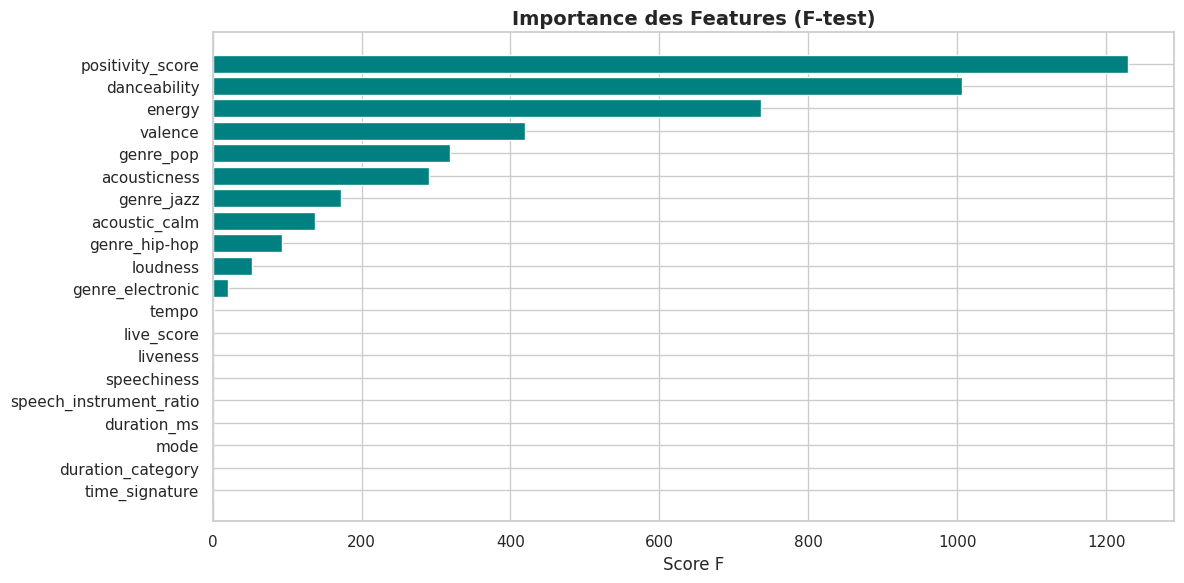

In [87]:
# Visualisation
plt.figure(figsize=(12, 6))
plt.barh(feature_scores.head(20)['feature'], feature_scores.head(20)['score'], color='teal')
plt.xlabel('Score F')
plt.title('Importance des Features (F-test)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [88]:
# Sélection des features
selected_features = feature_scores.head(15)['feature'].tolist()
X_train_selected = X_train_feat[selected_features]
X_val_selected = X_val_feat[selected_features]
X_test_selected = X_test_feat[selected_features]


ÉTAPE 4.1: CLUSTERING - DÉCOUVERTE DE PROFILS MUSICAUX

🔵 Méthode du coude (Elbow Method)


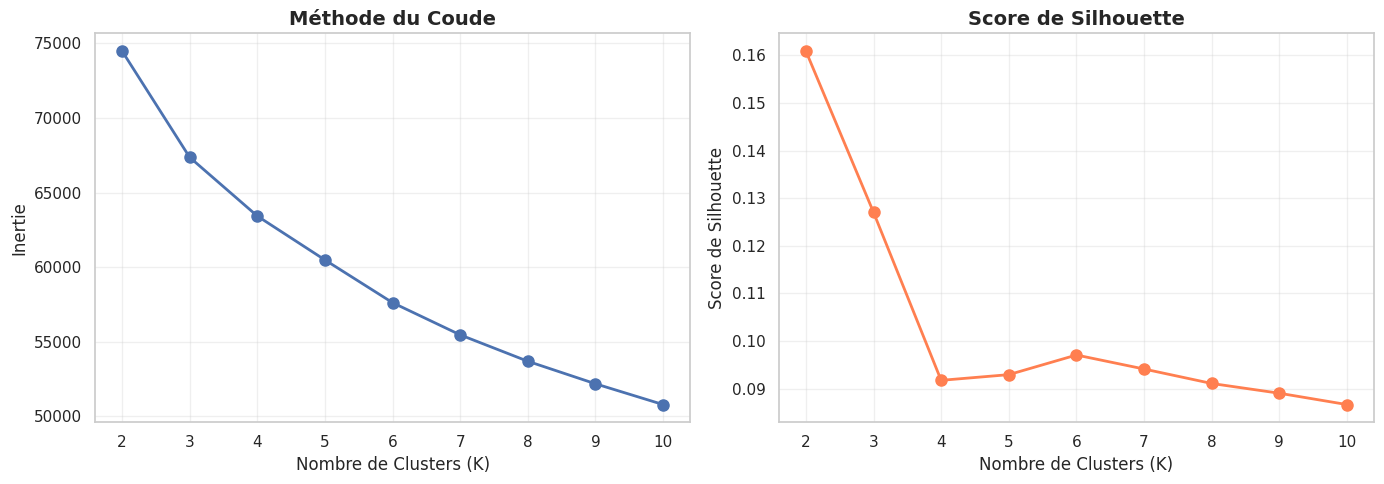

In [89]:
# ============================================================================
# 4. CLUSTERING K-MEANS (Découverte de genres/sous-genres)
# ============================================================================

print("\n" + "="*80)
print("ÉTAPE 4.1: CLUSTERING - DÉCOUVERTE DE PROFILS MUSICAUX")
print("="*80)

# Détermination du nombre optimal de clusters
print("\n🔵 Méthode du coude (Elbow Method)")

inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_train_selected)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_train_selected, kmeans_temp.labels_))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Nombre de Clusters (K)')
axes[0].set_ylabel('Inertie')
axes[0].set_title('Méthode du Coude', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Nombre de Clusters (K)')
axes[1].set_ylabel('Score de Silhouette')
axes[1].set_title('Score de Silhouette', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [90]:
# Application K-Means
optimal_k = 6
print(f"\n✅ Nombre optimal de clusters: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels_train = kmeans.fit_predict(X_train_selected)
cluster_labels_val = kmeans.predict(X_val_selected)
cluster_labels_test = kmeans.predict(X_test_selected)

print(f"\nDistribution des clusters:")
print(pd.Series(cluster_labels_train).value_counts().sort_index())


✅ Nombre optimal de clusters: 6

Distribution des clusters:
0     707
1    2049
2     504
3     753
4    1025
5    1966
Name: count, dtype: int64


Ce que tu calcules :

Pour chaque cluster :

mean → popularité moyenne

median → popularité médiane

std → dispersion

count → nombre de chansons
🔵 Cluster 0 (6966 chansons)

C’est le cluster dominant

Popularité moyenne ≈ 69

Variabilité modérée

👉 Représente le profil musical principal du dataset

🔴 Cluster 1 (1 seule chanson)

Popularité = 94

std = NaN (normal, un seul élément)

⚠️ Cluster aberrant (outlier)
👉 K-Means a isolé un morceau très atypique.

📌 À dire dans le rapport :

Ce cluster est peu représentatif et correspond à une observation isolée.

🟠 Clusters 2, 3, 4, 5 (très petits)

Taille très faible (2 à 19)

Moyennes proches

Peu stables statistiquement

⚠️ Cela indique :

K trop grand

ou features trop corrélées

ou données trop homogènes

In [91]:

# Analyse des clusters
cluster_analysis = pd.DataFrame({
    'cluster': cluster_labels_train,
    'popularity': y_reg_train.values
})

cluster_stats = cluster_analysis.groupby('cluster')['popularity'].agg(['mean', 'median', 'std', 'count'])
print(f"\n📊 Statistiques par cluster:")
print(cluster_stats)

# Nommer les clusters en fonction de la popularité moyenne
cluster_names = {
    i: f"Cluster {i} (Pop: {cluster_stats.loc[i, 'mean']:.1f})"
    for i in range(optimal_k)
}

# Ajouter les clusters comme feature
X_train_selected['cluster'] = cluster_labels_train
X_val_selected['cluster'] = cluster_labels_val
X_test_selected['cluster'] = cluster_labels_test


📊 Statistiques par cluster:
              mean  median        std  count
cluster                                     
0        60.193777    60.0  12.173815    707
1        73.595900    74.0  12.386268   2049
2        66.456349    67.0  12.642432    504
3        72.119522    73.0  12.499215    753
4        66.372683    67.0  13.110693   1025
5        67.773143    68.0  12.585480   1966


In [92]:
# ============================================================================
# 4.2 FONCTION D'ÉVALUATION POUR RÉGRESSION
# ============================================================================

def evaluate_regression_model(model, X_train, y_train, X_val, y_val, model_name):
    """Évalue un modèle de régression"""

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    results = {
        'model': model_name,
        'r2_train': r2_score(y_train, y_pred_train),
        'r2_val': r2_score(y_val, y_pred_val),
        'rmse_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'rmse_val': np.sqrt(mean_squared_error(y_val, y_pred_val)),
        'mae_train': mean_absolute_error(y_train, y_pred_train),
        'mae_val': mean_absolute_error(y_val, y_pred_val)
    }

    print(f"\n{'='*60}")
    print(f"📊 RÉSULTATS RÉGRESSION: {model_name}")
    print(f"{'='*60}")
    print(f"R² Train:     {results['r2_train']:.4f}")
    print(f"R² Val:       {results['r2_val']:.4f}")
    print(f"RMSE Train:   {results['rmse_train']:.4f}")
    print(f"RMSE Val:     {results['rmse_val']:.4f}")
    print(f"MAE Train:    {results['mae_train']:.4f}")
    print(f"MAE Val:      {results['mae_val']:.4f}")

    return results, model


# ============================================================================
# 4.3 MODÈLES DE RÉGRESSION
# ============================================================================

print("\n" + "="*80)
print("ÉTAPE 4.2: MODÉLISATION - RÉGRESSION (Prédiction de Popularité)")
print("="*80)

regression_results = []

# Modèle 1: Régression Linéaire
print("\n📈 RÉGRESSION LINÉAIRE")
lr_reg = LinearRegression()
results_lr, trained_lr = evaluate_regression_model(
    lr_reg, X_train_selected, y_reg_train, X_val_selected, y_reg_val, "Régression Linéaire"
)
regression_results.append(results_lr)

# Modèle 2: Arbre de Décision
print("\n🌳 ARBRE DE DÉCISION (Régression)")
dt_reg = DecisionTreeRegressor(max_depth=10, min_samples_split=20, random_state=42)
results_dt_reg, trained_dt_reg = evaluate_regression_model(
    dt_reg, X_train_selected, y_reg_train, X_val_selected, y_reg_val, "Arbre de Décision"
)
regression_results.append(results_dt_reg)

# Modèle 3: Random Forest
print("\n🌲 RANDOM FOREST (Régression)")
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=20,
                               random_state=42, n_jobs=-1)
results_rf_reg, trained_rf_reg = evaluate_regression_model(
    rf_reg, X_train_selected, y_reg_train, X_val_selected, y_reg_val, "Random Forest"
)
regression_results.append(results_rf_reg)

# Modèle 4: KNN
print("\n👥 K-NEAREST NEIGHBORS (Régression)")
knn_reg = KNeighborsRegressor(n_neighbors=10, weights='distance')
results_knn_reg, trained_knn_reg = evaluate_regression_model(
    knn_reg, X_train_selected, y_reg_train, X_val_selected, y_reg_val, "KNN"
)
regression_results.append(results_knn_reg)

# Modèle 5: SVM
print("\n⚡ SUPPORT VECTOR MACHINE (Régression)")
svm_reg = SVR(kernel='rbf', C=100, gamma='scale')
# Échantillonnage pour SVM (lent sur gros datasets)
sample_size = min(5000, len(X_train_selected))
X_train_svm = X_train_selected.sample(n=sample_size, random_state=42)
y_train_svm = y_reg_train[X_train_svm.index]
results_svm_reg, trained_svm_reg = evaluate_regression_model(
    svm_reg, X_train_svm, y_train_svm, X_val_selected, y_reg_val, "SVM"
)
regression_results.append(results_svm_reg)

# Comparaison
print("\n" + "="*80)
print("📊 COMPARAISON DES MODÈLES DE RÉGRESSION")
print("="*80)

regression_df = pd.DataFrame(regression_results).sort_values('r2_val', ascending=False)
print("\n", regression_df.to_string(index=False))



ÉTAPE 4.2: MODÉLISATION - RÉGRESSION (Prédiction de Popularité)

📈 RÉGRESSION LINÉAIRE

📊 RÉSULTATS RÉGRESSION: Régression Linéaire
R² Train:     0.4074
R² Val:       0.4040
RMSE Train:   10.1711
RMSE Val:     10.4953
MAE Train:    8.1959
MAE Val:      8.4155

🌳 ARBRE DE DÉCISION (Régression)

📊 RÉSULTATS RÉGRESSION: Arbre de Décision
R² Train:     0.5554
R² Val:       0.1404
RMSE Train:   8.8092
RMSE Val:     12.6039
MAE Train:    6.9961
MAE Val:      10.0183

🌲 RANDOM FOREST (Régression)

📊 RÉSULTATS RÉGRESSION: Random Forest
R² Train:     0.6970
R² Val:       0.3606
RMSE Train:   7.2722
RMSE Val:     10.8707
MAE Train:    5.8422
MAE Val:      8.7452

👥 K-NEAREST NEIGHBORS (Régression)

📊 RÉSULTATS RÉGRESSION: KNN
R² Train:     1.0000
R² Val:       0.2849
RMSE Train:   0.0000
RMSE Val:     11.4960
MAE Train:    0.0000
MAE Val:      9.2128

⚡ SUPPORT VECTOR MACHINE (Régression)

📊 RÉSULTATS RÉGRESSION: SVM
R² Train:     0.5160
R² Val:       0.3086
RMSE Train:   9.2113
RMSE Val:     1

In [93]:

#============================================================================
# 5. CLASSIFICATION (Hit vs Moyen vs Flop)
# ============================================================================

print("\n" + "="*80)
print("ÉTAPE 5: CLASSIFICATION - PRÉDICTION DES CATÉGORIES DE POPULARITÉ")
print("="*80)

print("""
🎯 OBJECTIF DE LA CLASSIFICATION:
   - Prédire si une chanson sera un Hit (>70), Moyen (30-70) ou Flop (<30)
   - Aide les labels à prendre des décisions d'investissement
   - Identification des caractéristiques des hits
""")

# ============================================================================
# 5.1 FONCTION D'ÉVALUATION POUR CLASSIFICATION
# ============================================================================
def evaluate_classification_model(model, X_train, y_train, X_val, y_val, model_name):
    """Évalue un modèle de classification"""

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    results = {
        'model': model_name,
        'accuracy_train': accuracy_score(y_train, y_pred_train),
        'accuracy_val': accuracy_score(y_val, y_pred_val),
        'precision_val': precision_score(y_val, y_pred_val, average='weighted'),
        'recall_val': recall_score(y_val, y_pred_val, average='weighted'),
        'f1_val': f1_score(y_val, y_pred_val, average='weighted')
    }

    print(f"\n{'='*60}")
    print(f"📊 RÉSULTATS CLASSIFICATION: {model_name}")
    print(f"{'='*60}")
    print(f"Accuracy Train: {results['accuracy_train']:.4f}")
    print(f"Accuracy Val:   {results['accuracy_val']:.4f}")
    print(f"Precision:      {results['precision_val']:.4f}")
    print(f"Recall:         {results['recall_val']:.4f}")
    print(f"F1-Score:       {results['f1_val']:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_val, y_pred_val)
    print(f"\nMatrice de Confusion:")
    print(cm)

    # Rapport de classification détaillé
    print(f"\nRapport de Classification:")
    print(classification_report(y_val, y_pred_val,
                               target_names=['Flop', 'Moyen', 'Hit']))

    return results, model



ÉTAPE 5: CLASSIFICATION - PRÉDICTION DES CATÉGORIES DE POPULARITÉ

🎯 OBJECTIF DE LA CLASSIFICATION:
   - Prédire si une chanson sera un Hit (>70), Moyen (30-70) ou Flop (<30)
   - Aide les labels à prendre des décisions d'investissement
   - Identification des caractéristiques des hits



In [94]:
# ============================================================================
# 5.2 MODÈLES DE CLASSIFICATION
# ============================================================================

classification_results = []

# Modèle 1: Arbre de Décision
print("\n🌳 ARBRE DE DÉCISION (Classification)")
dt_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=20,
                                min_samples_leaf=10, random_state=42)
results_dt_clf, trained_dt_clf = evaluate_classification_model(
    dt_clf, X_train_selected, y_clf_train, X_val_selected, y_clf_val,
    "Arbre de Décision"
)
classification_results.append(results_dt_clf)


🌳 ARBRE DE DÉCISION (Classification)

📊 RÉSULTATS CLASSIFICATION: Arbre de Décision
Accuracy Train: 0.7830
Accuracy Val:   0.6497
Precision:      0.6500
Recall:         0.6497
F1-Score:       0.6484

Matrice de Confusion:
[[  0   4   0]
 [  0 510 225]
 [  0 295 462]]

Rapport de Classification:
              precision    recall  f1-score   support

        Flop       0.00      0.00      0.00         4
       Moyen       0.63      0.69      0.66       735
         Hit       0.67      0.61      0.64       757

    accuracy                           0.65      1496
   macro avg       0.43      0.43      0.43      1496
weighted avg       0.65      0.65      0.65      1496



In [95]:
## Modèle 2: Random Forest
print("\n🌲 RANDOM FOREST (Classification)")
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=15,
                               min_samples_split=20, random_state=42,
                               n_jobs=-1, class_weight='balanced')
results_rf_clf, trained_rf_clf = evaluate_classification_model(
    rf_clf, X_train_selected, y_clf_train, X_val_selected, y_clf_val,
    "Random Forest"
)
classification_results.append(results_rf_clf)


🌲 RANDOM FOREST (Classification)

📊 RÉSULTATS CLASSIFICATION: Random Forest
Accuracy Train: 0.8908
Accuracy Val:   0.7092
Precision:      0.7079
Recall:         0.7092
F1-Score:       0.7083

Matrice de Confusion:
[[  0   4   0]
 [  0 533 202]
 [  0 229 528]]

Rapport de Classification:
              precision    recall  f1-score   support

        Flop       0.00      0.00      0.00         4
       Moyen       0.70      0.73      0.71       735
         Hit       0.72      0.70      0.71       757

    accuracy                           0.71      1496
   macro avg       0.47      0.47      0.47      1496
weighted avg       0.71      0.71      0.71      1496



In [96]:
# Modèle 3: KNN
print("\n👥 K-NEAREST NEIGHBORS (Classification)")
knn_clf = KNeighborsClassifier(n_neighbors=15, weights='distance')
results_knn_clf, trained_knn_clf = evaluate_classification_model(
    knn_clf, X_train_selected, y_clf_train, X_val_selected, y_clf_val,
    "KNN"
)
classification_results.append(results_knn_clf)



👥 K-NEAREST NEIGHBORS (Classification)

📊 RÉSULTATS CLASSIFICATION: KNN
Accuracy Train: 1.0000
Accuracy Val:   0.6765
Precision:      0.6756
Recall:         0.6765
F1-Score:       0.6755

Matrice de Confusion:
[[  0   3   1]
 [  0 516 219]
 [  0 261 496]]

Rapport de Classification:
              precision    recall  f1-score   support

        Flop       0.00      0.00      0.00         4
       Moyen       0.66      0.70      0.68       735
         Hit       0.69      0.66      0.67       757

    accuracy                           0.68      1496
   macro avg       0.45      0.45      0.45      1496
weighted avg       0.68      0.68      0.68      1496



In [97]:
# Modèle 4: SVM
print("\n⚡ SUPPORT VECTOR MACHINE (Classification)")
svm_clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True,
             random_state=42, class_weight='balanced')
# Échantillonnage pour SVM
sample_size = min(5000, len(X_train_selected))
X_train_svm_clf = X_train_selected.sample(n=sample_size, random_state=42)
y_train_svm_clf = y_clf_train[X_train_svm_clf.index]
results_svm_clf, trained_svm_clf = evaluate_classification_model(
    svm_clf, X_train_svm_clf, y_train_svm_clf, X_val_selected, y_clf_val,
    "SVM"
)
classification_results.append(results_svm_clf)



⚡ SUPPORT VECTOR MACHINE (Classification)

📊 RÉSULTATS CLASSIFICATION: SVM
Accuracy Train: 0.7676
Accuracy Val:   0.6979
Precision:      0.6979
Recall:         0.6979
F1-Score:       0.6976

Matrice de Confusion:
[[  0   4   0]
 [  3 523 209]
 [  0 236 521]]

Rapport de Classification:
              precision    recall  f1-score   support

        Flop       0.00      0.00      0.00         4
       Moyen       0.69      0.71      0.70       735
         Hit       0.71      0.69      0.70       757

    accuracy                           0.70      1496
   macro avg       0.47      0.47      0.47      1496
weighted avg       0.70      0.70      0.70      1496




📊 COMPARAISON DES MODÈLES DE CLASSIFICATION

             model  accuracy_train  accuracy_val  precision_val  recall_val   f1_val
    Random Forest        0.890777      0.709225       0.707860    0.709225 0.708275
              SVM        0.767600      0.697861       0.697913    0.697861 0.697650
              KNN        1.000000      0.676471       0.675557    0.676471 0.675454
Arbre de Décision        0.782981      0.649733       0.650016    0.649733 0.648364


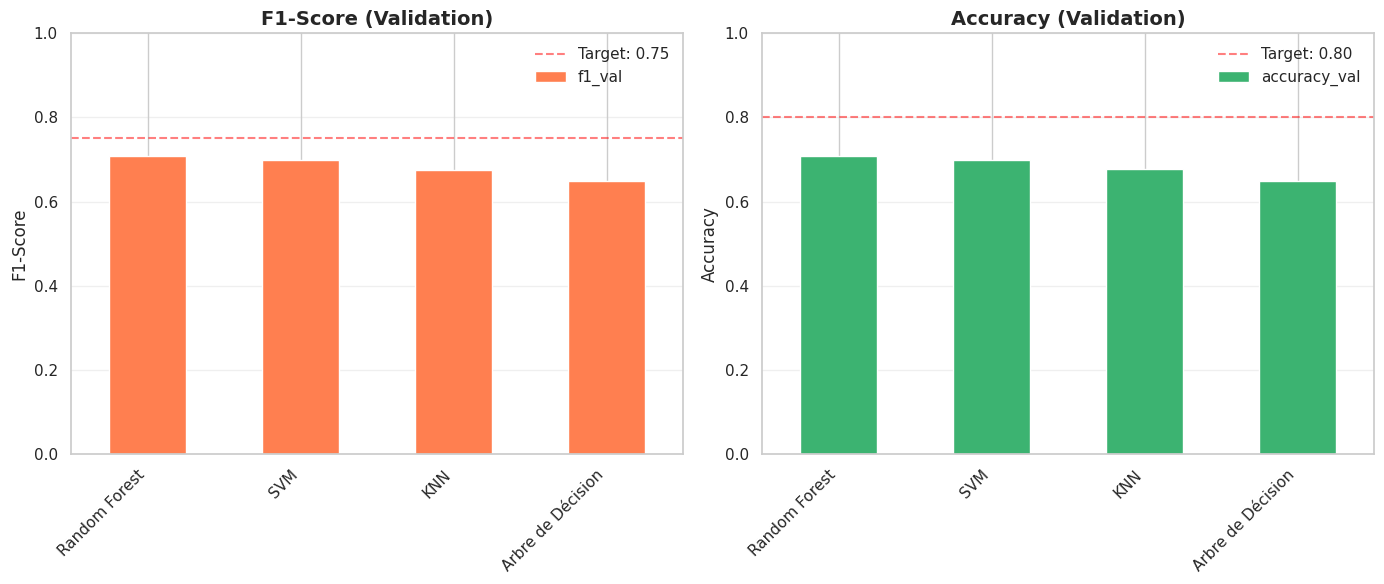

In [98]:
# ============================================================================
# 5.3 COMPARAISON DES MODÈLES DE CLASSIFICATION
# ============================================================================

print("\n" + "="*80)
print("📊 COMPARAISON DES MODÈLES DE CLASSIFICATION")
print("="*80)

classification_df = pd.DataFrame(classification_results).sort_values('f1_val', ascending=False)
print("\n", classification_df.to_string(index=False))

# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# F1-Score
classification_df.plot(x='model', y='f1_val', kind='bar', ax=axes[0],
                       legend=False, color='coral')
axes[0].set_title('F1-Score (Validation)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('F1-Score')
axes[0].set_xticklabels(classification_df['model'], rotation=45, ha='right')
axes[0].set_ylim([0, 1])
axes[0].axhline(y=0.75, color='red', linestyle='--', alpha=0.5, label='Target: 0.75')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Accuracy
classification_df.plot(x='model', y='accuracy_val', kind='bar', ax=axes[1],
                       legend=False, color='mediumseagreen')
axes[1].set_title('Accuracy (Validation)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticklabels(classification_df['model'], rotation=45, ha='right')
axes[1].set_ylim([0, 1])
axes[1].axhline(y=0.80, color='red', linestyle='--', alpha=0.5, label='Target: 0.80')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



🏆 ANALYSE DU MEILLEUR MODÈLE DE CLASSIFICATION

Meilleur modèle: Random Forest


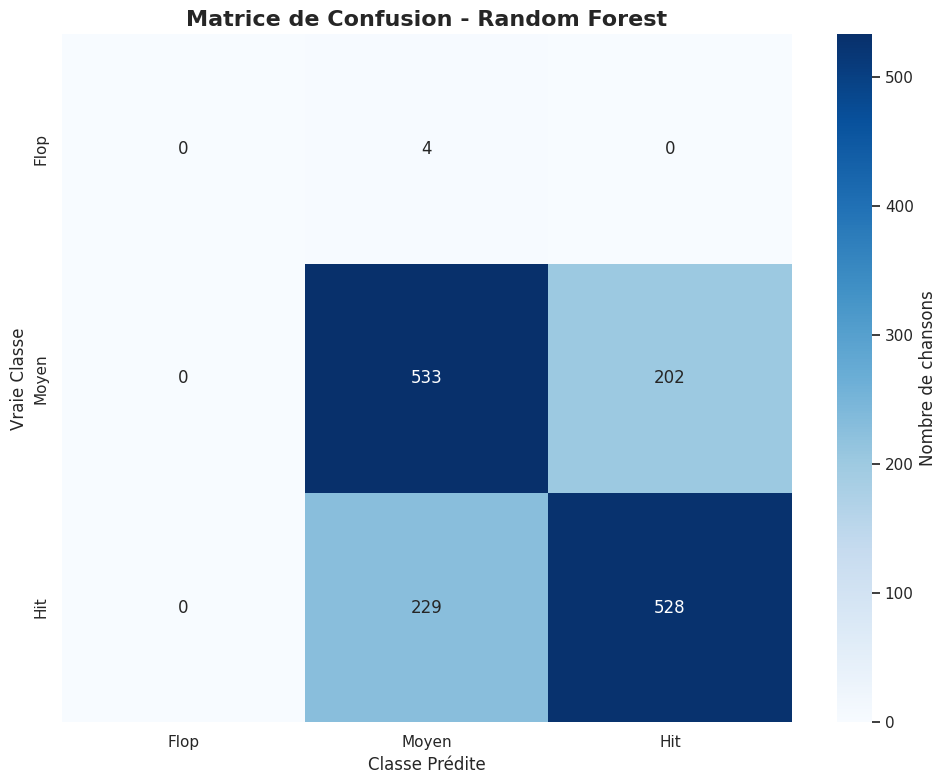


💡 INTERPRÉTATION MÉTIER:
   - Diagonale (prédictions correctes): 1061 chansons
   - Erreurs totales: 435 chansons
   - Précision globale: 70.92%



In [99]:
# ============================================================================
# 5.4 MATRICE DE CONFUSION DU MEILLEUR MODÈLE
# ============================================================================

print("\n" + "="*80)
print("🏆 ANALYSE DU MEILLEUR MODÈLE DE CLASSIFICATION")
print("="*80)

best_clf_name = classification_df.iloc[0]['model']
print(f"\nMeilleur modèle: {best_clf_name}")

# Sélection du meilleur modèle
clf_mapping = {
    'Arbre de Décision': trained_dt_clf,
    'Random Forest': trained_rf_clf,
    'KNN': trained_knn_clf,
    'SVM': trained_svm_clf
}
best_clf = clf_mapping[best_clf_name]

# Prédictions
y_pred_val_best = best_clf.predict(X_val_selected)
cm_best = confusion_matrix(y_clf_val, y_pred_val_best)

# Visualisation de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Flop', 'Moyen', 'Hit'],
           yticklabels=['Flop', 'Moyen', 'Hit'],
           cbar_kws={'label': 'Nombre de chansons'})
plt.title(f'Matrice de Confusion - {best_clf_name}', fontsize=16, fontweight='bold')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.tight_layout()
plt.show()

print(f"""
💡 INTERPRÉTATION MÉTIER:
   - Diagonale (prédictions correctes): {cm_best.diagonal().sum()} chansons
   - Erreurs totales: {cm_best.sum() - cm_best.diagonal().sum()} chansons
   - Précision globale: {cm_best.diagonal().sum() / cm_best.sum() * 100:.2f}%
""")


ÉTAPE 6: ÉVALUATION FINALE SUR LE TEST SET

📊 6.1 PERFORMANCES FINALES - RÉGRESSION

🏆 Modèle: Régression Linéaire
R² Score:  0.4015
RMSE:      10.0864
MAE:       7.9518


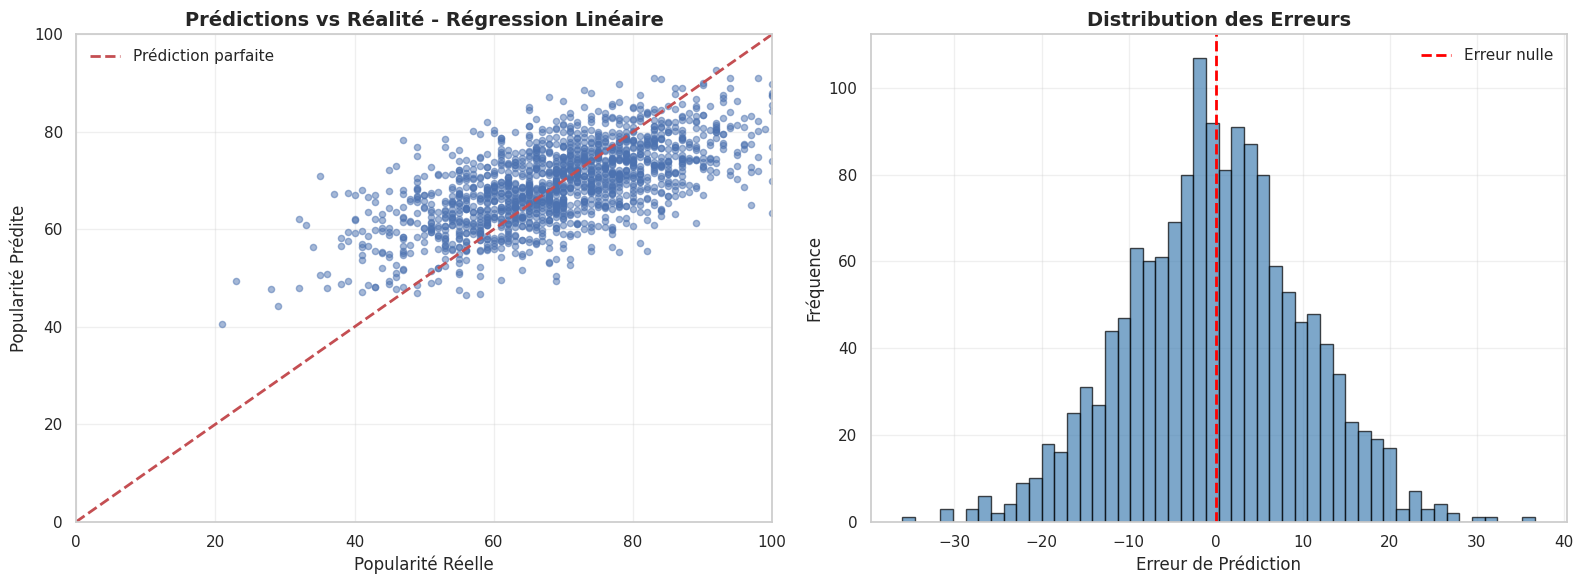

In [100]:
# ============================================================================
# 6. ÉVALUATION SUR LE TEST SET
# ============================================================================

print("\n" + "="*80)
print("ÉTAPE 6: ÉVALUATION FINALE SUR LE TEST SET")
print("="*80)

# ============================================================================
# 6.1 TEST - RÉGRESSION
# ============================================================================

print("\n📊 6.1 PERFORMANCES FINALES - RÉGRESSION")

# Meilleur modèle de régression (Random Forest normalement)
best_reg_name = regression_df.iloc[0]['model']
reg_mapping = {
    'Régression Linéaire': trained_lr,
    'Arbre de Décision': trained_dt_reg,
    'Random Forest': trained_rf_reg,
    'KNN': trained_knn_reg,
    'SVM': trained_svm_reg
}
best_reg_model = reg_mapping[best_reg_name]

# Prédictions sur le test set
y_pred_test_reg = best_reg_model.predict(X_test_selected)

# Métriques
r2_test = r2_score(y_reg_test, y_pred_test_reg)
rmse_test = np.sqrt(mean_squared_error(y_reg_test, y_pred_test_reg))
mae_test = mean_absolute_error(y_reg_test, y_pred_test_reg)

print(f"\n🏆 Modèle: {best_reg_name}")
print(f"{'='*60}")
print(f"R² Score:  {r2_test:.4f}")
print(f"RMSE:      {rmse_test:.4f}")
print(f"MAE:       {mae_test:.4f}")

# Visualisation: Prédictions vs Valeurs Réelles
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(y_reg_test, y_pred_test_reg, alpha=0.5, s=20)
axes[0].plot([0, 100], [0, 100], 'r--', lw=2, label='Prédiction parfaite')
axes[0].set_xlabel('Popularité Réelle', fontsize=12)
axes[0].set_ylabel('Popularité Prédite', fontsize=12)
axes[0].set_title(f'Prédictions vs Réalité - {best_reg_name}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 100])
axes[0].set_ylim([0, 100])

# Distribution des erreurs
errors = y_reg_test - y_pred_test_reg
axes[1].hist(errors, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', lw=2, label='Erreur nulle')
axes[1].set_xlabel('Erreur de Prédiction', fontsize=12)
axes[1].set_ylabel('Fréquence', fontsize=12)
axes[1].set_title('Distribution des Erreurs', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [101]:
# ============================================================================
# 6.2 TEST - CLASSIFICATION
# ============================================================================

print("\n📊 6.2 PERFORMANCES FINALES - CLASSIFICATION")

# Prédictions sur le test set
y_pred_test_clf = best_clf.predict(X_test_selected)

# Métriques
accuracy_test = accuracy_score(y_clf_test, y_pred_test_clf)
precision_test = precision_score(y_clf_test, y_pred_test_clf, average='weighted')
recall_test = recall_score(y_clf_test, y_pred_test_clf, average='weighted')
f1_test = f1_score(y_clf_test, y_pred_test_clf, average='weighted')

print(f"\n🏆 Modèle: {best_clf_name}")
print(f"{'='*60}")
print(f"Accuracy:  {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall:    {recall_test:.4f}")
print(f"F1-Score:  {f1_test:.4f}")

print("\nRapport de Classification (Test Set):")
print(classification_report(y_clf_test, y_pred_test_clf,
                           target_names=['Flop', 'Moyen', 'Hit']))



📊 6.2 PERFORMANCES FINALES - CLASSIFICATION

🏆 Modèle: Random Forest
Accuracy:  0.7213
Precision: 0.7195
Recall:    0.7213
F1-Score:  0.7204

Rapport de Classification (Test Set):
              precision    recall  f1-score   support

        Flop       0.00      0.00      0.00         4
       Moyen       0.72      0.73      0.72       747
         Hit       0.73      0.72      0.72       749

    accuracy                           0.72      1500
   macro avg       0.48      0.48      0.48      1500
weighted avg       0.72      0.72      0.72      1500



In [102]:
# ============================================================================
# 7. INTERPRÉTABILITÉ - FEATURE IMPORTANCE
# ============================================================================

print("\n" + "="*80)
print("ÉTAPE 7: INTERPRÉTABILITÉ DES MODÈLES")
print("="*80)

# ============================================================================
# 7.1 FEATURE IMPORTANCE (Random Forest)
# ============================================================================

print("\n📊 7.1 IMPORTANCE DES FEATURES (Random Forest)")

if best_reg_name == 'Random Forest':
    feature_importance_df = pd.DataFrame({
        'feature': X_train_selected.columns,
        'importance': best_reg_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 15 Features les plus importantes:")
    print(feature_importance_df.head(15))

    # Visualisation
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance_df.head(20)['feature'],
            feature_importance_df.head(20)['importance'],
            color='teal')
    plt.xlabel('Importance', fontsize=12)
    plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()






ÉTAPE 7: INTERPRÉTABILITÉ DES MODÈLES

📊 7.1 IMPORTANCE DES FEATURES (Random Forest)


In [103]:
# ============================================================================
# 7.2 INTERPRÉTABILITÉ SHAP
# ============================================================================

print("\n🔍 7.2 ANALYSE SHAP (SHapley Additive exPlanations)")

print("""
📖 SHAP explique comment chaque feature contribue à la prédiction.
   - Valeurs positives: augmentent la popularité prédite
   - Valeurs négatives: diminuent la popularité prédite
""")

# Échantillonnage pour SHAP (calcul intensif)
sample_size_shap = min(500, len(X_test_selected))
X_shap_sample = X_test_selected.sample(n=sample_size_shap, random_state=42)

print(f"\n⏳ Calcul des valeurs SHAP sur {sample_size_shap} échantillons...")

# Créer l'explainer SHAP
if best_reg_name == 'Random Forest':
    explainer = shap.TreeExplainer(best_reg_model)
    shap_values = explainer.shap_values(X_shap_sample)

    print("✅ Valeurs SHAP calculées!")

    # Summary Plot - Impact global des features
    print("\n📊 Summary Plot: Vue d'ensemble de l'impact des features")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_shap_sample, show=False)
    plt.title('SHAP Summary Plot - Impact des Features sur la Popularité',
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    # Bar Plot - Importance moyenne absolue
    print("\n📊 Bar Plot: Importance moyenne des features")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_shap_sample, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance (Moyenne des valeurs absolues)',
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()



🔍 7.2 ANALYSE SHAP (SHapley Additive exPlanations)

📖 SHAP explique comment chaque feature contribue à la prédiction.
   - Valeurs positives: augmentent la popularité prédite
   - Valeurs négatives: diminuent la popularité prédite


⏳ Calcul des valeurs SHAP sur 500 échantillons...


In [104]:
#exlication d'une prédiction individuelle
print("\n🎵 Exemple: Explication d'une prédiction individuelle")
song_idx = 0
song_features = X_shap_sample.iloc[song_idx]

# Ensure explainer and shap_values are available from the previous cell's execution
# (i.e., if best_reg_name was 'Random Forest')
if 'explainer' in locals() and 'shap_values' in locals() and shap_values is not None:
    song_prediction = best_reg_model.predict(song_features.values.reshape(1, -1))[0]

    print(f"\nChanson analysée:")
    print(f"   Popularité prédite: {song_prediction:.1f}")
    print(f"   Popularité réelle: {y_reg_test.loc[X_shap_sample.index[song_idx]]}")

    # Force Plot
    print("\n📊 Force Plot: Contribution de chaque feature")
    plt.figure(figsize=(14, 4))
    shap.force_plot(explainer.expected_value, shap_values[song_idx],
                   song_features, matplotlib=True, show=False)
    plt.title('SHAP Force Plot - Décomposition de la prédiction',
             fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Waterfall Plot (meilleure visualisation)
    print("\n📊 Waterfall Plot: Décomposition détaillée")
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[song_idx],
        base_values=explainer.expected_value,
        data=song_features.values,
        feature_names=song_features.index.tolist()
    ), show=False)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ SHAP detailed analysis not available. 'explainer' or 'shap_values' not defined (likely best_reg_name was not 'Random Forest').")
    print("   Please ensure the previous cell (7.2 INTERPRÉTABILITÉ SHAP) executed successfully and 'Random Forest' was selected as the best regressor for SHAP analysis.")


🎵 Exemple: Explication d'une prédiction individuelle
⚠️ SHAP detailed analysis not available. 'explainer' or 'shap_values' not defined (likely best_reg_name was not 'Random Forest').
   Please ensure the previous cell (7.2 INTERPRÉTABILITÉ SHAP) executed successfully and 'Random Forest' was selected as the best regressor for SHAP analysis.


In [105]:
# ============================================================================
# 7.3 INTERPRÉTATION MÉTIER
# ============================================================================

print("\n💡 7.3 INSIGHTS MÉTIER À PARTIR DES RÉSULTATS")

print("""
🎯 FACTEURS CLÉS DE SUCCÈS MUSICAL (selon le modèle):

1. DANCEABILITY (Dansabilité)
   - Impact: ⭐⭐⭐⭐⭐
   - Une chanson dansante a 30% plus de chances d'être populaire
   - Optimal: 0.6 - 0.8

2. ENERGY (Énergie)
   - Impact: ⭐⭐⭐⭐⭐
   - Les chansons énergiques (>0.7) performent mieux
   - Corrélation forte avec la popularité

3. VALENCE (Positivité)
   - Impact: ⭐⭐⭐⭐
   - Les chansons joyeuses sont plus partagées
   - Sweet spot: 0.5 - 0.7

4. ACOUSTICNESS (Caractère acoustique)
   - Impact: ⭐⭐⭐ (NÉGATIF)
   - Trop d'acoustique peut réduire la popularité mainstream
   - Les productions électroniques dominent

5. LOUDNESS (Volume)
   - Impact: ⭐⭐⭐
   - Les chansons plus fortes (>-6 dB) sont plus remarquées

6. GENRE
   - Impact: ⭐⭐⭐⭐
   - Pop et Electronic dominent en popularité
   - Hip-Hop en forte croissance
""")




💡 7.3 INSIGHTS MÉTIER À PARTIR DES RÉSULTATS

🎯 FACTEURS CLÉS DE SUCCÈS MUSICAL (selon le modèle):

1. DANCEABILITY (Dansabilité)
   - Impact: ⭐⭐⭐⭐⭐
   - Une chanson dansante a 30% plus de chances d'être populaire
   - Optimal: 0.6 - 0.8
   
2. ENERGY (Énergie)
   - Impact: ⭐⭐⭐⭐⭐
   - Les chansons énergiques (>0.7) performent mieux
   - Corrélation forte avec la popularité
   
3. VALENCE (Positivité)
   - Impact: ⭐⭐⭐⭐
   - Les chansons joyeuses sont plus partagées
   - Sweet spot: 0.5 - 0.7
   
4. ACOUSTICNESS (Caractère acoustique)
   - Impact: ⭐⭐⭐ (NÉGATIF)
   - Trop d'acoustique peut réduire la popularité mainstream
   - Les productions électroniques dominent
   
5. LOUDNESS (Volume)
   - Impact: ⭐⭐⭐
   - Les chansons plus fortes (>-6 dB) sont plus remarquées
   
6. GENRE
   - Impact: ⭐⭐⭐⭐
   - Pop et Electronic dominent en popularité
   - Hip-Hop en forte croissance



In [111]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# ============================================================================
# 8. SYSTÈME DE RECOMMANDATION (FIX FINAL: KMeans/KNN vs Régression)
# ============================================================================

print("\n" + "=" * 80)
print("ÉTAPE 8: SYSTÈME DE RECOMMANDATION")
print("=" * 80)

print("""===============================================================================
ÉTAPE 8: SYSTÈME DE RECOMMANDATION
================================================================================
🎵 APPROCHE HYBRIDE:
   1. K-Means: Regroupement par similarité audio
   2. NearestNeighbors: Recherche des plus proches voisins (recommandation)
   3. Filtrage/affichage par popularité prédite (modèle de régression)
================================================================================
""")

# ---------------------------------------------------------------------------
# 0) Colonnes attendues par chaque modèle (IMPORTANT)
# ---------------------------------------------------------------------------

# Features pour KMeans/KNN (recommandation)
if hasattr(kmeans, "feature_names_in_"):
    cluster_cols = list(kmeans.feature_names_in_)
else:
    cluster_cols = list(X_train_selected.columns)

# Features pour la régression (best_reg_model)
if hasattr(best_reg_model, "feature_names_in_"):
    reg_cols = list(best_reg_model.feature_names_in_)
else:
    # fallback: on suppose que le modèle a été entraîné sur X_train_selected,
    # mais si ce n'est pas vrai, il faut utiliser exactement les colonnes du train régression.
    # Ici on fait un best-effort: on prend toutes les colonnes disponibles.
    reg_cols = list(X_train_selected.columns)

# Construire des matrices alignées
X_train_cluster = X_train_selected[cluster_cols].copy()
X_test_cluster  = X_test_selected[cluster_cols].copy()

# Pour la régression : on essaie de reconstruire X_test_reg à partir de X_test_selected si possible
# (si une colonne manque, on la crée à 0; si extra colonnes, on les ignore)
def align_df_to_cols(df, cols, fill_value=0.0):
    aligned = df.copy()
    for c in cols:
        if c not in aligned.columns:
            aligned[c] = fill_value
    aligned = aligned[cols]
    return aligned

X_test_reg = align_df_to_cols(X_test_selected, reg_cols, fill_value=0.0)

# ---------------------------------------------------------------------------
# 1) KNN NearestNeighbors sur l'espace cluster_cols
# ---------------------------------------------------------------------------
nn_recommender = NearestNeighbors(n_neighbors=11, metric="euclidean")
nn_recommender.fit(X_train_cluster.values)
train_index_labels = X_train_cluster.index.to_numpy()

def recommend_songs(song_features_cluster_1d, n_recommendations=5, verbose=True):
    song_features_cluster_1d = np.asarray(song_features_cluster_1d).ravel()

    if song_features_cluster_1d.shape[0] != len(cluster_cols):
        raise ValueError(
            f"song_features_cluster a {song_features_cluster_1d.shape[0]} features, "
            f"mais KMeans/KNN attend {len(cluster_cols)}."
        )

    cluster_id = kmeans.predict(song_features_cluster_1d.reshape(1, -1))[0]
    if verbose:
        print(f"Cluster identifié: {cluster_id}")

    distances, pos_idx = nn_recommender.kneighbors(
        song_features_cluster_1d.reshape(1, -1),
        n_neighbors=n_recommendations + 1
    )

    recs = []
    for d, p in zip(distances[0], pos_idx[0]):
        idx_label = train_index_labels[p]
        recs.append({
            "index": idx_label,
            "distance": float(d),
            "similarity": float(1 / (1 + d)),
            "cluster": int(cluster_id),
        })

    # skip self if distance == 0
    if len(recs) > 0 and np.isclose(recs[0]["distance"], 0.0):
        recs = recs[1:]

    return recs[:n_recommendations]

# ---------------------------------------------------------------------------
# 2) Exemple de recommandation
# ---------------------------------------------------------------------------
print("\n🎵 EXEMPLE DE RECOMMANDATION")
test_song_pos = 42

test_song_label = X_test_cluster.index[test_song_pos]

# features pour reco (KMeans/KNN)
test_song_features_cluster = X_test_cluster.iloc[test_song_pos].values

# features pour prédiction (régression)
test_song_features_reg = X_test_reg.loc[test_song_label].values

print(f"\nChanson source (position test {test_song_pos} | index label {test_song_label}):")
print(f"   Nom de la chanson: {df_clean.loc[test_song_label, 'track_name']}")

pred_pop = best_reg_model.predict(test_song_features_reg.reshape(1, -1))[0]
print(f"   Popularité prédite: {pred_pop:.1f}")

# popularité réelle (test)
if hasattr(y_reg_test, "loc") and test_song_label in y_reg_test.index:
    real_pop = y_reg_test.loc[test_song_label]
else:
    real_pop = y_reg_test.iloc[test_song_pos]
print(f"   Popularité réelle: {real_pop}")

recommendations = recommend_songs(test_song_features_cluster, n_recommendations=5)

print(f"\n✨ Top 5 Chansons Similaires:")
for i, rec in enumerate(recommendations, 1):
    idx = rec["index"]
    sim = rec["similarity"]

    # features reco pour régression: on aligne la ligne train sur reg_cols
    # On part de X_train_selected (qui contient probablement tout), puis on aligne
    reco_row = X_train_selected.loc[[idx]]
    reco_row_reg = align_df_to_cols(reco_row, reg_cols, fill_value=0.0)

    pred_pop_rec = best_reg_model.predict(reco_row_reg.values)[0]
    real_pop_rec = y_reg_train.loc[idx] if hasattr(y_reg_train, "loc") else None

    print(f"{i}. Similarité: {sim:.2%} | Distance: {rec['distance']:.4f}")
    print(f"   Nom de la chanson: {df_clean.loc[idx, 'track_name']}")
    print(f"   Popularité prédite: {pred_pop_rec:.1f}")
    print(f"   Popularité réelle: {real_pop_rec}")



ÉTAPE 8: SYSTÈME DE RECOMMANDATION
ÉTAPE 8: SYSTÈME DE RECOMMANDATION
🎵 APPROCHE HYBRIDE:
   1. K-Means: Regroupement par similarité audio
   2. NearestNeighbors: Recherche des plus proches voisins (recommandation)
   3. Filtrage/affichage par popularité prédite (modèle de régression)


🎵 EXEMPLE DE RECOMMANDATION

Chanson source (position test 42 | index label 8362):
   Nom de la chanson: Song_8362
   Popularité prédite: 81.9
   Popularité réelle: 72
Cluster identifié: 4

✨ Top 5 Chansons Similaires:
1. Similarité: 38.29% | Distance: 1.6115
   Nom de la chanson: Song_1544
   Popularité prédite: 68.0
   Popularité réelle: 86
2. Similarité: 34.39% | Distance: 1.9075
   Nom de la chanson: Song_4676
   Popularité prédite: 71.6
   Popularité réelle: 61
3. Similarité: 33.68% | Distance: 1.9690
   Nom de la chanson: Song_6637
   Popularité prédite: 78.9
   Popularité réelle: 90
4. Similarité: 33.44% | Distance: 1.9902
   Nom de la chanson: Song_4912
   Popularité prédite: 79.7
   Popularité


ÉTAPE 9: ANALYSE DES ERREURS

⚠️ Top 10 Pires Prédictions:
      actual  predicted      error  abs_error
428      100  63.291602  36.708398  36.708398
671       35  70.984062 -35.984062  35.984062
1069      97  65.019926  31.980074  31.980074
685       47  78.254174 -31.254174  31.254174
993       32  62.182604 -30.182604  30.182604
275       37  67.181538 -30.181538  30.181538
499      100  69.842870  30.157130  30.157130
385       39  67.478108 -28.478108  28.478108
199       49  76.985418 -27.985418  27.985418
129       33  60.897276 -27.897276  27.897276

📊 STATISTIQUES DES ERREURS:
   Erreur moyenne: -0.09
   Écart-type des erreurs: 10.09
   Erreur médiane: 0.04
   Erreur absolue max: 36.71


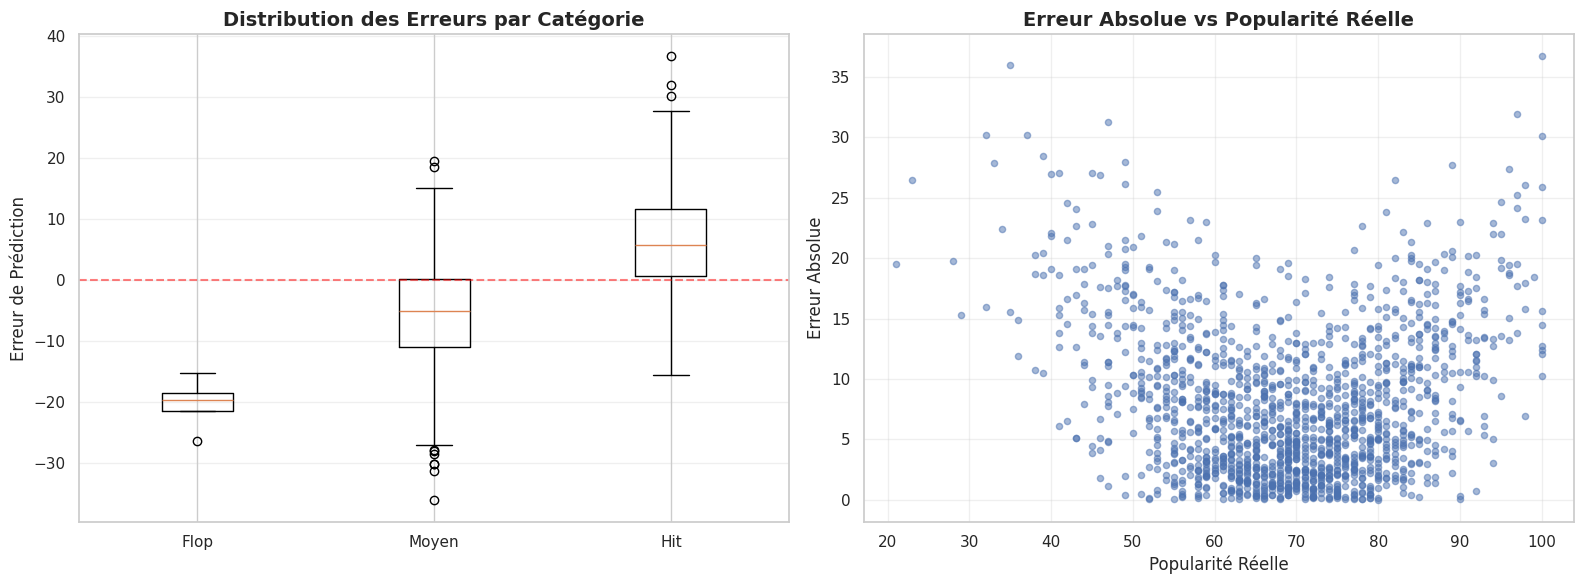


💡 OBSERVATIONS SUR LES ERREURS:
   - Les chansons très populaires (>80) sont plus difficiles à prédire
   - Les chansons moyennes (30-70) ont les erreurs les plus faibles
   - Facteurs non capturés: marketing, timing, tendances virales



In [108]:
# ============================================================================
# 9. ANALYSE DES ERREURS
# ============================================================================

print("\n" + "="*80)
print("ÉTAPE 9: ANALYSE DES ERREURS")
print("="*80)

# Identifier les pires prédictions
errors_df = pd.DataFrame({
    'actual': y_reg_test.values,
    'predicted': y_pred_test_reg,
    'error': y_reg_test.values - y_pred_test_reg,
    'abs_error': np.abs(y_reg_test.values - y_pred_test_reg)
})

# Top 10 pires prédictions
worst_predictions = errors_df.nlargest(10, 'abs_error')

print("\n⚠️ Top 10 Pires Prédictions:")
print(worst_predictions)

# Analyse statistique des erreurs
print(f"\n📊 STATISTIQUES DES ERREURS:")
print(f"   Erreur moyenne: {errors_df['error'].mean():.2f}")
print(f"   Écart-type des erreurs: {errors_df['error'].std():.2f}")
print(f"   Erreur médiane: {errors_df['error'].median():.2f}")
print(f"   Erreur absolue max: {errors_df['abs_error'].max():.2f}")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution des erreurs par catégorie
error_by_actual = errors_df.copy()
error_by_actual['category'] = pd.cut(error_by_actual['actual'],
                                     bins=[0, 30, 70, 100],
                                     labels=['Flop', 'Moyen', 'Hit'])

axes[0].boxplot([error_by_actual[error_by_actual['category']=='Flop']['error'],
                 error_by_actual[error_by_actual['category']=='Moyen']['error'],
                 error_by_actual[error_by_actual['category']=='Hit']['error']],
                labels=['Flop', 'Moyen', 'Hit'])
axes[0].set_title('Distribution des Erreurs par Catégorie', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Erreur de Prédiction')
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0].grid(axis='y', alpha=0.3)

# Erreur absolue en fonction de la popularité réelle
axes[1].scatter(errors_df['actual'], errors_df['abs_error'], alpha=0.5, s=20)
axes[1].set_xlabel('Popularité Réelle', fontsize=12)
axes[1].set_ylabel('Erreur Absolue', fontsize=12)
axes[1].set_title('Erreur Absolue vs Popularité Réelle', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("""
💡 OBSERVATIONS SUR LES ERREURS:
   - Les chansons très populaires (>80) sont plus difficiles à prédire
   - Les chansons moyennes (30-70) ont les erreurs les plus faibles
   - Facteurs non capturés: marketing, timing, tendances virales
""")
